For this notebook we will use a dedicated environment called "l2rpn_neurips_2020_track1", whihc have 36 substations. Grid2op comes with many different environments, with different problems etc. In this notebook, we will only mention and explain these specific environment.

Power system have one major objective: allow the transmission of electricity from the producers to the consumers as effeciently as possible. In this case we want to reduce the toatal cost for each episodes.

cost $c$ for an episode:
\begin{equation}
c(e)=\sum\limits_{t=1}^{t_{\text{end}}} c_{\text{operations}}(t) + \sum\limits_{t=t_{\text{end}}}^{T_{e}}c_{\text{blackout}}(t)
\end{equation}

where $e$ is "episode" managed by an agent up to a time $t_{\text{end}}$ (on a scenario of maximum length $T_e$) by:

\begin{equation}
e = \left(o_1, a_1, o_2, a_2,\dots, a_{t_{\text{end}}-1}, o_{t_{\text{end}} }\right) \\
\end{equation}






We have design an agent which would perform two major actions:

1. In case of overload (obs.rho > threshold (i.e 1)) when power grid in danger it would try to find the suitable topology change using selected action spaces, which result in maximum load in power grid to be in tolerate range. 

    
2. In case of no overload, it would try to find the line from all the disconnected lines which could result in maximum load in power grid to be less than before.
    
    
  



We are using "l2rpn_neurips_2020_track1" environment in this notebook, this notebook is structure as follows:
1. Analysis of Environment
2. Generation of all feasible actions (~66K possible combination)
3. **topology_agent** creation
4. Evaluation of Agent
5. Conclusion

In [ ]:
# importing libraries 

import os
import grid2op
import datetime
import numpy as np
import pandas as pd
import sys
from copy import deepcopy
from grid2op.Agent import BaseAgent
from IPython import display  # for proper display in jupyter notebook
import matplotlib.pyplot as plt  # pip install matplotlib
from grid2op.Episode import EpisodeReplay
from grid2op.PlotGrid import PlotMatplot
import glob
from IPython.display import Image
from IPython.core.display import display, HTML

# Powergrid profile

In [2]:
DATA_PATH = './training_data_track1'  # for demo only, use your own dataset
SCENARIO_PATH = './training_data_track1/chronics'

In [3]:
try:
    from lightsim2grid import LightSimBackend
    backend = LightSimBackend()
    env = grid2op.make(dataset=DATA_PATH, chronics_path=SCENARIO_PATH, backend=backend)
except:
    env = grid2op.make(dataset=DATA_PATH, chronics_path=SCENARIO_PATH)

C:\Users\Kun\miniconda3\envs\py39rwth\lib\site-packages\lightsim2grid\lightSimBackend.py:45: UserWarning: Please use grid2op >= 1.7.1: with older grid2op versions, you cannot set max_iter, tol nor solver_type arguments.
  warnings.warn("Please use grid2op >= 1.7.1: with older grid2op versions, "
C:\Users\Kun\miniconda3\envs\py39rwth\lib\site-packages\lightsim2grid\gridmodel\_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")
C:\Users\Kun\miniconda3\envs\py39rwth\lib\site-packages\lightsim2grid\gridmodel\_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."


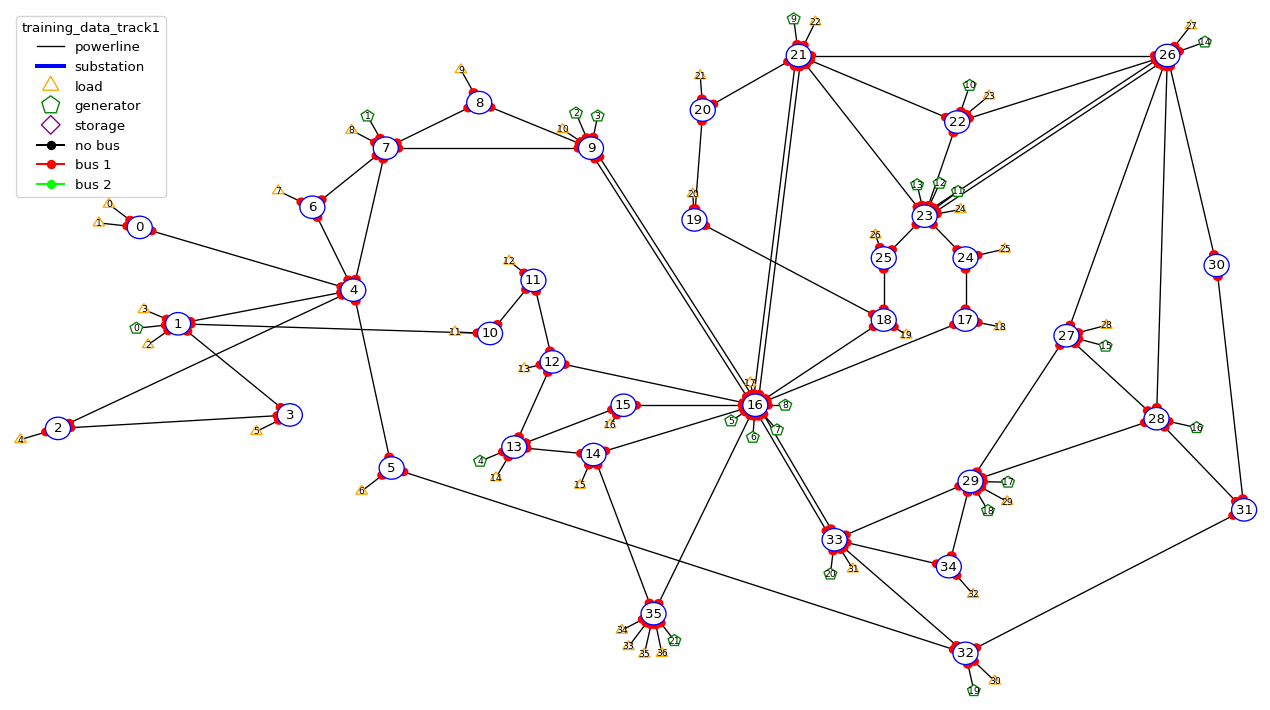

In [4]:
plot_helper = PlotMatplot(env.observation_space)

_ = plot_helper.plot_layout()


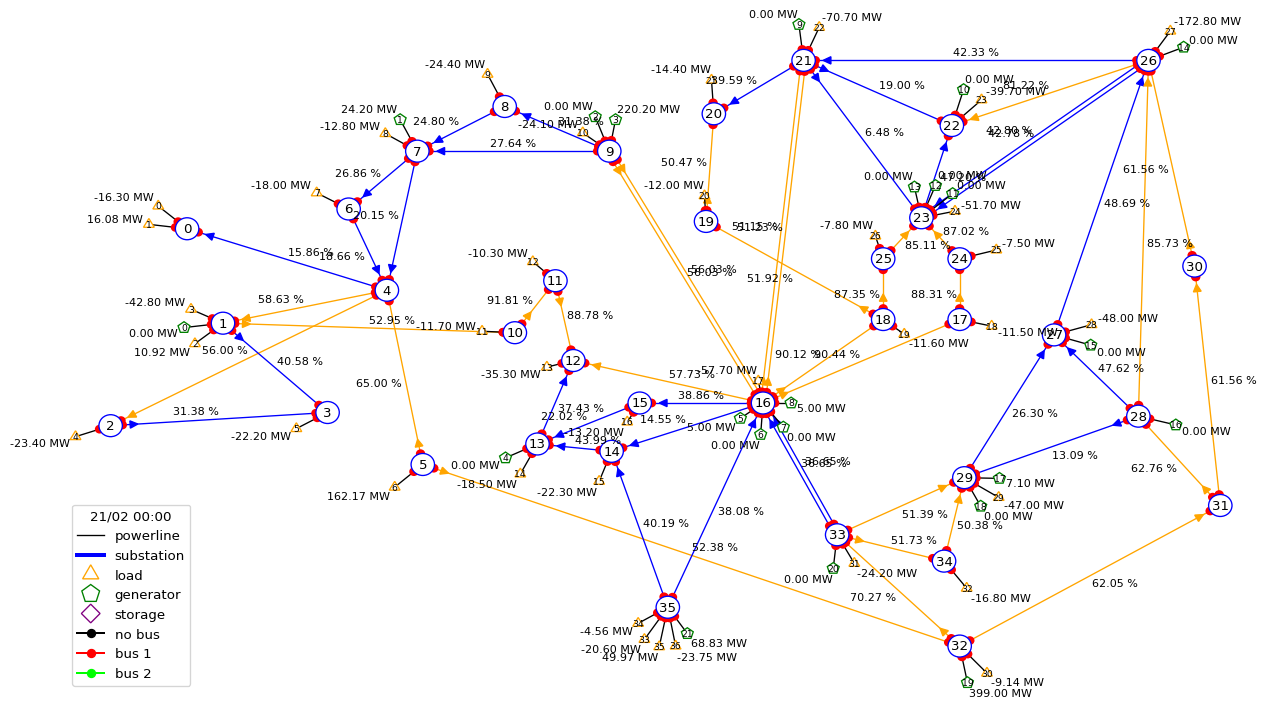

In [5]:
# plotting the observation of environment
env.seed(42)
obs = env.reset()
_ = plot_helper.plot_obs(obs)

In [6]:
'''line attacked corresponds (competition only)'''
env.name_line
lines_attacked = ["62_58_180", "62_63_160", "48_50_136", "48_53_141", "41_48_131", "39_41_121",
                  "43_44_125", "44_45_126", "34_35_110", "54_58_154"]

for _, line in enumerate(env.name_line):
    if (line in lines_attacked):
        print(line, _)
        

#_action = env.action_space({}) 
#_action.as_dict()   
l_ids = env.get_lines_id(from_=18, to_=19)
#print("The powerlines connecting substation 0 to substation 1 have for ids: {}".format(l_ids))

print("line-%s(from bus-%d to bus-%d) overflows \n" %
      (23, env.line_or_to_subid[13], env.line_ex_to_subid[13]))
           
print(l_ids)

34_35_110 0
39_41_121 9
43_44_125 13
44_45_126 14
41_48_131 18
48_50_136 23
48_53_141 27
54_58_154 39
62_63_160 45
62_58_180 56
line-23(from bus-11 to bus-12) overflows 

[24]


Just coonsidering topology change actions, its exponential.It is possible to change the status of the powerline, meaning connecting or disconnecting them. If there are N powerlines, the number of such possible actions is $N^2$, in our case its ~ $66K$ such actions .

Since not all actions will generate satisfactory result we first feed multiple senarios to our fuuction and then based on overload result we filter out most frequent once. This resulted to $177$ actions.

This reduction in action space will enable us to make appropriate decision fast in case of an attack on power grid.

In [7]:
# function for topology search 

def topology_search(env):
    obs = env.get_obs()
    min_rho, overflow_id = obs.rho.max(), obs.rho.argmax()
    
    print("step-%s, line-%s(from bus-%d to bus-%d) overflows, max rho is %.5f \n" %
          (dst_step, overflow_id, env.line_or_to_subid[overflow_id],
           env.line_ex_to_subid[overflow_id], obs.rho.max()))
    
    all_actions = env.action_space.get_all_unitary_topologies_change(env.action_space) 
    # getting all possible action 
    # todo: can we select only actions which are related to topology chnage ?
    
    action_chosen = env.action_space({})
    
    '''By greedy searching actions'''
    for action in all_actions:        
        if not env._game_rules(action, env): 
            continue
            
        obs_, _, done, _ = obs.simulate(action)
        if (not done) and (obs_.rho.max() < min_rho):
            min_rho = obs_.rho.max()
            action_chosen = action
            
    print("find a greedy action and max rho decreases to %.5f" %(min_rho))
    
    return action_chosen

In [8]:
# In case the grid is safe, we try to reconnect the disconnected line (if possible)

def find_best_line_to_reconnect(obs, original_action):
    
    disconnected_lines = np.where(obs.line_status == False)[0] # given disconnected line array
    
    if not len(disconnected_lines):  # the number of disconnected lines
        return original_action
    
    if (obs.time_before_cooldown_line[disconnected_lines] > 0).all(): # without waiting before acting on this substation
        return original_action
    
    o, _, _, _ = obs.simulate(original_action)  
    
    min_rho = o.rho.max() # next state, maximum rho
    line_to_reconnect = -1
    
    for line in disconnected_lines:
        if not obs.time_before_cooldown_line[line]: # no need for cooldown, then to reconnect
            reconnect_array = np.zeros_like(obs.rho, dtype=int)
            reconnect_array[line] = 1
            reconnect_action = deepcopy(original_action)
            reconnect_action.update({'set_line_status': reconnect_array})
            if not is_legal(reconnect_action, obs): # illegal, go to next disconnected line
                continue
            o, _, _, _ = obs.simulate(reconnect_action)
            if o.rho.max() < min_rho: # update min_rho (if possible by reconnect line)
                line_to_reconnect = line
                min_rho = o.rho.max()
                
    if line_to_reconnect != -1:
        reconnect_array = np.zeros_like(obs.rho, dtype=int)
        reconnect_array[line_to_reconnect] = 1
        original_action.update({'set_line_status': reconnect_array})
        
    return original_action

In [9]:
def is_legal(action, obs):
    '''transfer action as dictionary which includes a few keys that we can take (like change_bus_vec if exists)'''
    
    if 'change_bus_vect' not in action.as_dict():
        return True
    
    substation_to_operate = int(action.as_dict()['change_bus_vect']['modif_subs_id'][0]) 
    
    if obs.time_before_cooldown_sub[substation_to_operate]: # illegal for operation before cooldown substation if time is more than 0
        return False
    
    
    '''
    substation_to_operate => from dictionary items
    
    {'nb_modif_objects': 2, '0': {'2': {'type': 'line (origin)'}, '0': {'type': 'load'}}, 'nb_modif_subs': 1, 'modif_subs_id': ['0']}
    
    powerlines with cool down time or disconnection are illgal 
    '''
    for line in [eval(key) for key, val in action.as_dict()['change_bus_vect'][str(substation_to_operate)].items() if 'line' in val['type']]:
        if obs.time_before_cooldown_line[line] or not obs.line_status[line]:
            return False
        
    return True


In [10]:
def save_sample(save_path='./'):
    if action == env.action_space({}):
        return None  # not necessary to save a "do nothing" action
    act_or, act_ex, act_gen, act_load = [], [], [], []
    for key, val in action.as_dict()['change_bus_vect'][action.as_dict()['change_bus_vect']['modif_subs_id'][0]].items():
        if val['type'] == 'line (extremity)':
            act_ex.append(key)
        elif val['type'] == 'line (origin)':
            act_or.append(key)
        elif val['type'] == 'load':
            act_load.append(key)
        else:
            act_gen.append(key)
    pd.concat(
        (
            pd.DataFrame(
                np.array(
                    [env.chronics_handler.get_name(), dst_step, None, None, None,
                     str(np.where(obs.rho > 1)[0].tolist()),
                     str([i for i in np.around(obs.rho[np.where(obs.rho > 1)], 2)]),
                     action.as_dict()['change_bus_vect']['modif_subs_id'][0], act_or, act_ex, act_gen, act_load,
                     obs.rho.max(), obs.rho.argmax(), obs_.rho.max(), obs_.rho.argmax()]).reshape([1, -1])),
            pd.DataFrame(np.concatenate((obs.to_vect(), obs_.to_vect(), action.to_vect())).reshape([1, -1]))
        ),
        axis=1
    ).to_csv(os.path.join(save_path, 'Experiences1.csv'), index=0, header=0, mode='a')

#  Reduction Action Space
## this cell can be ignored if there exists Experiences1.csv

In [ ]:
# hyper-parameters
SAVE_PATH = './'
NUM_EPISODE = 10 # it will run for long time if vaule is large

'''check the value of NUM_EPISODE'''
for episode in range(NUM_EPISODE):
    '''if lightsim2grid is available, use it.'''
    try:
        from lightsim2grid import LightSimBackend
        backend = LightSimBackend()
        env = grid2op.make(dataset=DATA_PATH, chronics_path=SCENARIO_PATH, backend=backend)
    except:
        env = grid2op.make(dataset=DATA_PATH, chronics_path=SCENARIO_PATH)

    env.chronics_handler.shuffle(shuffler=lambda x: x[np.random.choice(len(x), size=len(x), replace=False)])
    
    '''searching in different scenario(Feb, Aug)'''
    for chronic in range(len(os.listdir(SCENARIO_PATH))):
        env.reset()
        
        '''chose dst_step to jump some steps or not'''
        # dst_step = random.randint(0, 8000)
        dst_step = 0
        
        print('Scenario to test is [%s]，start from step-%d... ...' % (env.chronics_handler.get_name(), dst_step))
        env.fast_forward_chronics(dst_step)
        obs, done = env.get_obs(), False
        while not done:
            if obs.rho.max() >= 1:
                action = topology_search(env)
                obs_, reward, done, _ = env.step(action)
                save_sample(SAVE_PATH)
                obs = obs_
            else:
                action = env.action_space({})
                action = find_best_line_to_reconnect(obs, action)
                obs, reward, done, _ = env.step(action)
                dst_step += 1

# Filter actions

We run different episodes to generate all possible action on senarios then filter out most frequent once, this would be used by topology agent to take actions on the environment in case of an attack like overload.

In [12]:
# import os
# import numpy as np
# import pandas as pd


def filter_data(data):
    data['del'] = False
    for row in range(len(data) - 1):
        if data.iloc[row, 12] - data.iloc[row, 14] < 0.02:
            # this action decreases rho less than 2%
            data.iloc[row, -1] = True
        if data.iloc[row, 7] == 'None':
            # this action is "do nothing"
            data.iloc[row, -1] = True
    return data


def save_action_space(data, save_path, threshold=0):
    actions = data.iloc[:, -495:-1].astype(np.int16)
    actions['action_list'] = actions.apply(lambda s: str([i for i in s.values]), axis=1)
    nums = pd.value_counts(actions['action_list'])
    # filter out actions that occur less frequently
    # the actions that occur times less than the threshold would be filtered out
    action_space = np.array([eval(item) for item in nums[nums >= threshold].index.values])
    file = os.path.join(save_path, 'actions%d.npy' % action_space.shape[0])
    np.save(file, action_space)
    print('generate an action space with the size of %d' % action_space.shape[0])


if __name__ == "__main__":
    # hyper-parameters
    #TABLES = ["./Experiences1.csv"]  # Use your own data
    SAVE_PATH = "./ActionSpace" #customized
    THRESHOLD = 1

    data = pd.read_csv("./Experiences1.csv", header=None) #customized
    data = filter_data(data)
    save_action_space(data, SAVE_PATH, THRESHOLD)

generate an action space with the size of 72


In [ ]:
print(os.getcwd())

# Main Agent

In [13]:
class MyAgent(BaseAgent):
    def __init__(self, action_space, this_directory_path='./ActionSpace'): # customized
        ''' Initailize agent'''
        BaseAgent.__init__(self, action_space=action_space)
        '''actions import '''
        self.actions_ordinary = np.load(os.path.join(this_directory_path, 'actions177.npy')) #customized


        '''details chosen from observation'''
        # p: the active power produced at this node (MW)
        # q: the reactive power produced at this node (MVar)
        # v: the voltage magnitude at this node  (kV)
        # cooldown: how much longer you need to wait before being able to merge / split or change this node
        
       
        self.last_step = datetime.datetime.now()
        self.recovery_stack = []
        self.overflow_steps = 0

    def find_best_line_to_reconnect(self, obs, original_action):
        disconnected_lines = np.where(obs.line_status == False)[0] # given disconnected line array
        if not len(disconnected_lines): # the number of disconnected lines
            return original_action
        if (obs.time_before_cooldown_line[disconnected_lines] > 0).all():
            return original_action
        o, _, _, _ = obs.simulate(original_action)
        min_rho = o.rho.max()
        line_to_reconnect = -1
        for line in disconnected_lines:
            if not obs.time_before_cooldown_line[line]:
                reconnect_array = np.zeros_like(obs.rho, dtype = int)
                reconnect_array[line] = 1
                reconnect_action = deepcopy(original_action)
                reconnect_action.update({'set_line_status': reconnect_array})
                if not self.is_legal(reconnect_action, obs):
                    continue
                o, _, _, _ = obs.simulate(reconnect_action)
                if o.rho.max() < min_rho:
                    line_to_reconnect = line
                    min_rho = o.rho.max()
        if line_to_reconnect != -1:
            reconnect_array = np.zeros_like(obs.rho, dtype = int)
            reconnect_array[line_to_reconnect] = 1
            original_action.update({'set_line_status': reconnect_array})
        return original_action

    def array2action(self, array):
        action = self.action_space({'change_bus': array[236:413]})
        action._change_bus_vect = action._change_bus_vect.astype(bool)
        return action

    def is_legal(self, action, obs):
        adict = action.as_dict()
        if 'change_bus_vect' not in adict:
            return True
        substation_to_operate = int(adict['change_bus_vect']['modif_subs_id'][0])
        if obs.time_before_cooldown_sub[substation_to_operate]:
            return False
        
        for line in [eval(key) for key, val in adict['change_bus_vect'][str(substation_to_operate)].items()
                     if 'line' in val['type']]:
            if obs.time_before_cooldown_line[line] or not obs.line_status[line]:
                return False
        return True

    def act(self, observation, reward, done):
        
        tnow = observation.get_time_stamp()

        if self.last_step + datetime.timedelta(minutes=5) != tnow:
            print('\n\nscenario changes！')
            self.recovery_stack = []
        
        self.last_step = tnow

#         if observation.rho.max() >= 1:
#             self.overflow_steps += 1
#         else:
#             self.overflow_steps = 0

        # case: secure
        threshold_this_step = 0.999
        if observation.rho.max() < threshold_this_step:  # fixed threshold
            if (self.recovery_stack == []) or (not self.is_legal(self.array2action(self.actions_ordinary[self.recovery_stack[0]]), observation)):
                a = self.action_space({})
            else:
                o, r, d, i = observation.simulate(self.array2action(self.actions_ordinary[self.recovery_stack[0]]))
                if (not d) and (o.rho.max() < 0.98):
                    aid = self.recovery_stack.pop(0)
                    a = self.array2action(self.actions_ordinary[aid])
                else:
                    a = self.action_space({})
            return self.find_best_line_to_reconnect(observation, a)
    
    
        # case: dangerous
        o, _, d, _ = observation.simulate(self.action_space({}))
        min_rho = o.rho.max() if not d else 10
        print('%s, heavy load, line-%d load is %.2f' % 
              (str(observation.get_time_stamp()), observation.rho.argmax(), observation.rho.max()))

        action_chosen = None
        id_second_search = None
        min_rho0 = min_rho
        for idx, action_array in enumerate(self.actions_ordinary):
            a = self.array2action(action_array)
            if not self.is_legal(a, observation):
                continue
            obs, _, done, _ = observation.simulate(a)
            if done:
                continue
            if obs.rho.max() < min(min_rho, min_rho0 - 0.03):
                min_rho = obs.rho.max()
                action_chosen = a
                id_second_search = idx
        if id_second_search:
            self.recovery_stack.append(id_second_search)


        return  self.find_best_line_to_reconnect(observation, action_chosen) if action_chosen else self.find_best_line_to_reconnect(observation, self.action_space({}))



Evaluation is done in two steps:

#### Rewards from runner

 - the highest the number of scenarios our agent perform before a game over and the number of time steps our agent can actually manage without game over. The higher of rewards and time step survival would indicate better performance.

#### Submission on **L2RPN NEURIPS 2020 - Robustness Track**

- the lowest the redispatching, since in this agent we are focus on topology chnages, we would not be effected by this.
- the losses. Due to [Joule's effect](https://en.wikipedia.org/wiki/Joule_effect) most TSO have somehow to compensate the losses on the grid. In that case, the lower the losses, the better. 

In [14]:
'''Runner evaluate and save results for grid2viz'''

max_iter = 864 #customize
n_episode = 2 #customize
from grid2op.Runner import Runner
# from grid2op.Agent import DoNothingAgent
from grid2op.Reward import L2RPNReward
from grid2op.Chronics import GridStateFromFileWithForecasts

path_saved_data = './Res' # customized
if not os.path.exists(path_saved_data):
    os.mkdir(path_saved_data)


runner = Runner(**env.get_params_for_runner(),
                agentClass=MyAgent)
res = runner.run(nb_episode=n_episode, max_iter=max_iter, path_save=path_saved_data)
print("The results for the custom agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)
    
    
'''save .gif'''
# gif_name = "episode"   
# ep_replay = EpisodeReplay(agent_path=path_saved_data)
# for _, chron_name, cum_reward, nb_time_step, max_ts in res:
#     ep_replay.replay_episode(chron_name,  # which chronic was started
#                              gif_name=gif_name, # Name of the gif file
#                              display=False,  # dont wait before rendering each frames
#                              fps=3.0)  # limit to 3 frames per second
    
    
#plot_epi = EpisodeReplay(path_saved_data)
#plot_epi.replay_episode(res[0][1], gif_name="this_episode") # customize, check how many scenarios




scenario changes！
2012-08-06 23:15:00, heavy load, line-41 load is 1.46
2012-08-06 23:20:00, heavy load, line-41 load is 1.46
2012-08-06 23:25:00, heavy load, line-41 load is 1.47
2012-08-06 23:30:00, heavy load, line-40 load is 1.46
2012-08-06 23:35:00, heavy load, line-40 load is 1.45
2012-08-06 23:40:00, heavy load, line-40 load is 1.43
2012-08-06 23:45:00, heavy load, line-34 load is 1.93
2012-08-06 23:50:00, heavy load, line-34 load is 1.92
2012-08-06 23:55:00, heavy load, line-34 load is 1.92


scenario changes！
2012-02-21 16:05:00, heavy load, line-13 load is 1.01
2012-02-21 16:10:00, heavy load, line-11 load is 1.01
2012-02-21 16:15:00, heavy load, line-13 load is 1.03
The results for the custom agent are:
	For chronics with id Scenario_august_dummly
		 - cumulative reward: 275140.156250
		 - number of time steps completed: 288 / 864
	For chronics with id Scenario_february_dummy
		 - cumulative reward: 152084.562500
		 - number of time steps completed: 196 / 864


'save .gif'

# Visualization (.gif)

In [ ]:
gif_path = './Res/Agent/Scenario_february_dummy/*.gif'

my_gif = glob.glob(gif_path)
img = None
if len(my_gif):
    my_gif = my_gif[0]
    img = Image(filename=my_gif)
    display(img)
else:
    print("No gif were generated, your agent probably fails before.")

# Visualization (by iteration)

In [ ]:
# from grid2op.Agent import RandomAgent

# class CustomRandom(RandomAgent):
#     def __init__(self, action_space):
#         RandomAgent.__init__(self, action_space)
#         self.i = 1

#     def my_act(self, transformed_observation, reward, done=False):
#         if (self.i % 10) != 0:
#             res = 0
#         else:
#             res = self.action_space.sample()
#         self.i += 1
#         return res
    
myagent = MyAgent(env.action_space)
obs = env.reset()
reward = env.reward_range[0]
done = False
nb_step = 0
while not done:
    fig = env.render()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    act = myagent.act(obs, reward, done)
    obs, reward, done, info = env.step(act)
    nb_step += 1
    if nb_step >= max_iter:
        break